## Poisson regression on real data in R


In this lesson, we will analyze real data using the Poisson regression model. A video will accompany this notebook.

The goal of the `bike` data is to keep count of cyclists entering and leaving Queens, Manhattan and Brooklyn via the East River Bridges. The Traffic Information Management System (TIMS) collected this count data for several months during 2017. Each record represents the total number of cyclists per 24 hours at Brooklyn Bridge, Manhattan Bridge, Williamsburg Bridge, and Queensboro Bridge. Also included in the dataset are date and temperature imformation.

Column Name	and Column Description

1. `date`: Date the count was conducted


2. `day`: Day of the week the count was conducted


3. `temp_h`: The high temperature for that day in fahrenheit


4. `temp_l`:	The low temperature for that night in fahrenheit


5. `precip`:	The amount of precipitation for that day in inches


6. `bb`: Total number of cyclist counts at Brooklyn Bridge in a 24 hour period


7. `mb`: Total number of cyclist counts at Manhattan Bridge in a 24 hour period


8. `wb`: Total number of cyclist counts at Williamburg Bridge in a 24 hour period


9. `qb`:	Total number of cyclist counts at Queensboro Bridge in a 24 hour period


10. `total`: The number of cyclist counts for all the East River Bridges combined in a 24 hour period

**Our goal will be to try to use the weather data to explain the total number of cyclists on the Manhattan Bridge on any given day.**

First, we'll load the data into R using the `RCurl` package's `getURL()` function:

In [1]:
#similar analysis https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958library(dplyr)
library(lubridate) #for the ymd() function
library(RCurl)
library(tidyverse)

#read in the data (paste0() allows for text wrapping)
urlfile = paste0("https://raw.githubusercontent.com/bzaharatos/",
                "-Statistical-Modeling-for-Data-Science-Applications/master/",
                 "Generalized%20Linear%20Models%20and%20Nonparametric%20Regression/",
                 "Datasets/2017%20Monthly%20Bike%20Count%20Totals%20for%20East%20River%20Bridges/bike.csv")
url = getURL(urlfile)
#bike = na.omit(read.csv(text = url, sep = ",", header = TRUE))
bike = read.csv(text = url, sep = ",", header = TRUE)

#check for NA
sum(is.na(bike$mb))

head(bike, 10)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: bitops
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ tidyr::complete()        masks RCurl::complete()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdi

[1] 0

date,day,temp_h,temp_l,precip,bb,mb,wb,qb,total
4/1,Saturday,46.0,37.0,0.00,606,1446,1915,1430,5397
4/2,Sunday,62.1,41.0,0.00,2021,3943,4207,2862,13033
4/3,Monday,63.0,50.0,0.03,2470,4988,5178,3689,16325
4/4,Tuesday,51.1,46.0,1.18,723,1913,2279,1666,6581
4/5,Wednesday,63.0,46.0,0.00,2807,5276,5711,4197,17991
4/6,Thursday,48.9,41.0,0.73,461,1324,1739,1372,4896
4/7,Friday,48.0,43.0,T,1222,2955,3399,2765,10341
4/8,Saturday,55.9,39.9,0.00,1674,3163,4082,2691,11610
4/9,Sunday,66.0,45.0,0.00,2375,4377,4886,3261,14899
4/10,Monday,73.9,55.0,0.00,3324,6359,6881,4731,21295


Note: $T = $ trace precipitation. Let's think of trace precipitation as no precipitation for now...

In [2]:
#replace T for 0...
bike = bike %>%
    mutate(precip = fct_recode(precip, "0" = "T"))
    #mutate(precip=replace(precip, precip== "T", NA))

bike$precip
#check data types
sapply(bike, class)

[1] 0.00 0.00 0.03 1.18 0.00 0.73 0    0.00 0.00 0.00 0.00 0.02 0.00 0.00 0.00
 [16] 0    0    0.00 0    0.17 0.29 0.11 0.00 0    0.91 0.34 0.00 0.00 0.06 0.00
 [31] 0.00 0.00 0.00 0.00 3.02 0.18 0.01 0.00 0.00 0.00 0.00 0.00 1.31 0.02 0.00
 [46] 0.00 0.00 0.00 0.00 0.01 0.00 0.59 0.00 0.04 0.58 0.10 0.00 0.00 0.13 0.06
 [61] 0.03 0.00 0.01 0.01 0.09 0.02 0.06 0.00 0.00 0.00 0.00 0.00 0.00 0    0.29
 [76] 0.00 0.00 1.39 0    1.35 0.03 0.00 0.00 0.04 1.29 0.00 0.00 0.18 0.00 0.00
 [91] 0    0.23 0.00 0.45 0.00 0.00 0    1.78 0.00 0.00 0.00 0.00 0.00 0.00 0.35
[106] 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.57 0.06 0.74 0.00 0.00 0    0.00 0.00
[121] 0.00 0.00 0.00 0.09 0.00 0.15 0.30 0.00 0.76 0.00 0.00 0.00 0    0.11 0.00
[136] 0.00 0.45 0.00 0.00 0.88 0.00 0.00 0.00 0.30 0    0.00 0.00 0.00 0.00 0.00
[151] 0.10 0.01 0.00 0.00 0.53 0.74 0.00 0    0.42 0.01 0.00 0.00 0.00 0.00 0.00
[166] 0.06 0.02 0.00 0.00 0.00 0.00 0.22 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
[181] 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.22 0.26 0.00 0.06 0.07
[196] 0.00 0.08 0    0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.20 0.00 0.00 0.00
[211] 0.00 3.03 0.25 0.00
44 Levels: 0.00 0.01 0.02 0.03 0.04 0.06 0.07 0.08 0.09 0.10 0.11 0.13 ... 0

date       day    temp_h    temp_l    precip        bb        mb        wb 
 "factor"  "factor" "numeric" "numeric"  "factor" "numeric" "numeric" "numeric" 
       qb     total 
"numeric" "numeric"

Notice that we'll need to do some additional data cleaning. In particular, many of the variables are being recognized as factors even though they shouldn't be (e.g., the bridge counts, and precip). Also, we can store the `date` variable as a date. 

In [3]:
#wrangle the data
bike = bike %>%
    mutate(temp_h = as.numeric(temp_h),temp_l = as.numeric(temp_l)) %>%
    mutate(mb = as.numeric(as.character(mb)),bb = as.numeric(as.character(bb)), 
           wb = as.numeric(as.character(wb)), qb = as.numeric(as.character(qb)),
           total = as.numeric(as.character(total))) %>%
    mutate(date = as.Date(as.character(date),format='%m/%d')) %>%
    mutate(precip = as.numeric(as.character(precip)))
           
#fix the year of the date variable
bike$date = ymd(as.character(bike$date)) - years(3)

#summarize and confirm data types
summary(bike)
sapply(bike, class)
head(bike)

      date                   day         temp_h         temp_l     
 Min.   :2017-04-01   Friday   :30   Min.   :46.0   Min.   :37.00  
 1st Qu.:2017-05-24   Monday   :31   1st Qu.:66.9   1st Qu.:55.23  
 Median :2017-07-16   Saturday :31   Median :75.9   Median :64.00  
 Mean   :2017-07-16   Sunday   :31   Mean   :74.2   Mean   :62.03  
 3rd Qu.:2017-09-07   Thursday :30   3rd Qu.:82.0   3rd Qu.:70.00  
 Max.   :2017-10-31   Tuesday  :31   Max.   :93.9   Max.   :78.10  
                      Wednesday:30                                 
     precip             bb             mb             wb             qb      
 Min.   :0.0000   Min.   : 151   Min.   : 484   Min.   : 874   Min.   : 865  
 1st Qu.:0.0000   1st Qu.:2298   1st Qu.:4308   1st Qu.:5115   1st Qu.:3746  
 Median :0.0000   Median :2857   Median :5608   Median :6287   Median :4681  
 Mean   :0.1318   Mean   :2680   Mean   :5345   Mean   :6052   Mean   :4550  
 3rd Qu.:0.0375   3rd Qu.:3285   3rd Qu.:6760   3rd Qu.:7512   3rd

date       day    temp_h    temp_l    precip        bb        mb        wb 
   "Date"  "factor" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
       qb     total 
"numeric" "numeric"

date,day,temp_h,temp_l,precip,bb,mb,wb,qb,total
2017-04-01,Saturday,46.0,37,0.00,606,1446,1915,1430,5397
2017-04-02,Sunday,62.1,41,0.00,2021,3943,4207,2862,13033
2017-04-03,Monday,63.0,50,0.03,2470,4988,5178,3689,16325
2017-04-04,Tuesday,51.1,46,1.18,723,1913,2279,1666,6581
2017-04-05,Wednesday,63.0,46,0.00,2807,5276,5711,4197,17991
2017-04-06,Thursday,48.9,41,0.73,461,1324,1739,1372,4896


Now, we see that each variable is stored correctly. 

For predictive performance purposes, let's split the data into a training set - on which we'll fit the model - and a testing set - on which we'll make "out of sample" predictions". Let's train the model on 80\% of the data, and save about 20\% for validation.

In [4]:
set.seed(8585)
bound = floor(nrow(bike)*0.8) #define % of training and test set

df = bike[sample(nrow(bike)), ]       #sample rows 
df_train = df[1:bound, ]              #get training set
df_test = df[(bound+1):nrow(bike), ]  #get test set

Let's fit a Poisson regression model on the data!

In [5]:
glm_bike = glm(mb ~ precip + temp_h + temp_l + day, data = df_train, family = poisson)
summary(glm_bike)
cat("If precipitation is increased by one inch, we would expect the mean number of bikes across the manhattan bridge to be multiplied by", 
    exp(coef(glm_bike)[2]))


Call:
glm(formula = mb ~ precip + temp_h + temp_l + day, family = poisson, 
    data = df_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-41.577   -7.122    2.309    8.523   38.973  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   7.7605007  0.0088089  880.98   <2e-16 ***
precip       -0.6733753  0.0049519 -135.98   <2e-16 ***
temp_h        0.0232326  0.0002333   99.59   <2e-16 ***
temp_l       -0.0139666  0.0002524  -55.34   <2e-16 ***
dayMonday     0.0758621  0.0038756   19.57   <2e-16 ***
daySaturday  -0.1993917  0.0042215  -47.23   <2e-16 ***
daySunday    -0.2618583  0.0043404  -60.33   <2e-16 ***
dayThursday   0.0999425  0.0038607   25.89   <2e-16 ***
dayTuesday    0.1419263  0.0038452   36.91   <2e-16 ***
dayWednesday  0.1580572  0.0038413   41.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 110729  on 17

If precipitation is increased by one inch, we would expect the mean number of bikes across the manhattan bridge to be multiplied by 0.5099843

This is helpful, but we might want to be more fine-grained in our interpretation. A one inch increase in precipitation can be a lot. Perhaps we'd want to know what a one standard deviation increase would look like. To do so, let's scale the data, and note the standard deviation of the precipitation variable (in the training set):

In [6]:
cat("The standard deviation of precipitation is", sd(df_train$precip),".")
df_train_scale = df_train %>% mutate_at(c("precip", "temp_h", "temp_l"), scale)

The standard deviation of precipitation is 0.3755631 .

In [7]:
glm_bike_scale = glm(mb ~ precip + temp_h + temp_l + day, data = df_train_scale, family = poisson)
coef(glm_bike_scale)
cat(paste0("Assuming the model is correct, if precipitation is increased by",
           "one standard deviation (0.38 inches), we would expect the mean ",
           "number of bikes across the manhattan bridge to be multiplied by"), 
    exp(coef(glm_bike_scale)[2]),"adjusting for tempteratures, and day of week.")

(Intercept)       precip       temp_h       temp_l    dayMonday  daySaturday 
  8.52140068  -0.25289490   0.23726473  -0.12827691   0.07586209  -0.19939172 
   daySunday  dayThursday   dayTuesday dayWednesday 
 -0.26185827   0.09994253   0.14192629   0.15805716

Assuming the model is correct, if precipitation is increased byone standard deviation (0.38 inches), we would expect the mean number of bikes across the manhattan bridge to be multiplied by 0.7765495 adjusting for tempteratures, and day of week.

Of course, we have not yet studied whether this model is correct. One simple assessment that we can look at is a plot of the predicted values ($\widehat\mu$) vs the true values for either the training set, or the the out-of-sample (test) set. In the training set, we see points aligning along $y=x$, but with some variability, suggesting that the fit could be better.

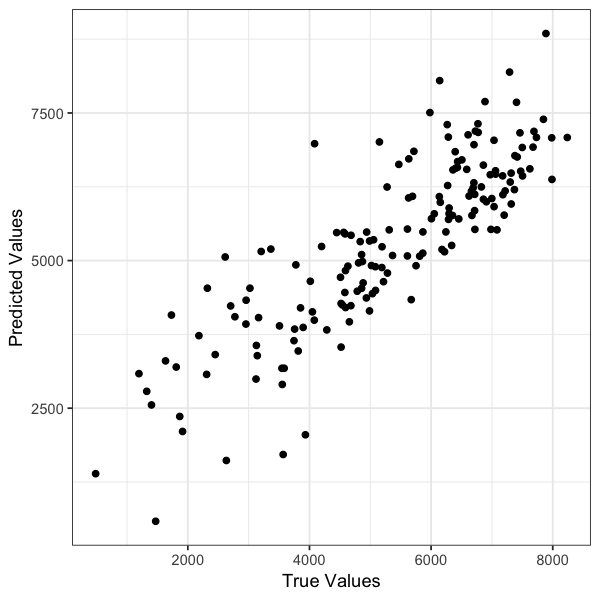

In [8]:
n_train = length(df_train$mb)
n_test = length(df_test$mb)

mu_train = predict(glm_bike, df_train, type="response")
y_train = df_train$mb

options(repr.plot.width = 5, repr.plot.height = 5)
df_test_predict = data.frame(y_train, mu_train)
p = ggplot(df_test_predict) + geom_point(aes(y_train, mu_train))
p = p + theme_bw()
p = p + xlab("True Values") + ylab("Predicted Values")
p

The same plot on the test set shows a bit more variability, further suggesting that the model fit is less than optimal.

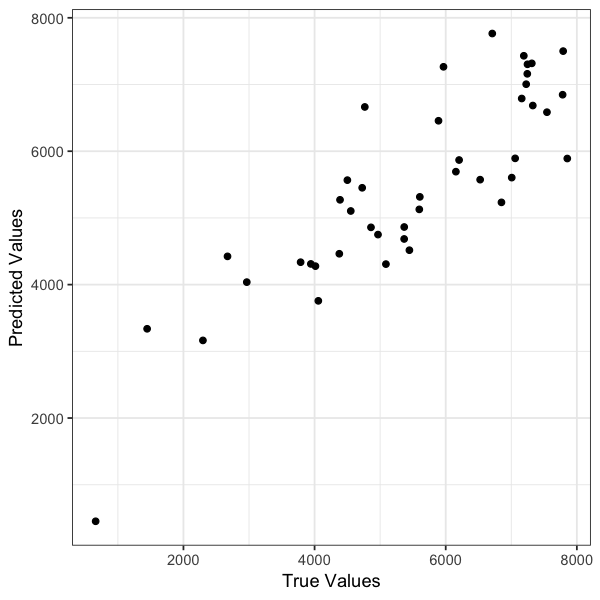

In [9]:
n_train = length(df_train$mb)
n_test = length(df_test$mb)

mu_test = predict(glm_bike, df_test, type="response")
y_test = df_test$mb

options(repr.plot.width = 5, repr.plot.height = 5)
df_test_predict = data.frame(y_test, mu_test)
p = ggplot(df_test_predict) + geom_point(aes(y_test, mu_test))
p = p + theme_bw()
p = p + xlab("True Values") + ylab("Predicted Values")
p